# PRODUCT RECOGNITION ON STORE SHELVES

### Manuel Gabrielli - manuel.gabrielli@studio.unibo.it


---


Develop a computer vision system that, given a reference image for each product, is able to identify boxes of cereals of different brands from one picture of a store shelf. For each type of product displayed in the shelf the system should report:
1. Number of instances.
2. Dimension of each instance (width and height of the bounding box that enclose them in pixel).

<img src="img/imageAssignment1.png" width="520"><br>

3. Position in the image reference system of each instance (center of the bounding box that enclose them in pixel).

For example, as output of the above image the system should print:

<img src="Img/imageAssignment2.png" width="700"><br>

## Step A - Multiple Product Detection

- Test on scene image: {e1.png, e2.png, e3.png, e4.png, e5.png}
- Use product images: {0.jpg, 1.jpg, 11.jpg, 19.jpg, 24.jpg, 25.jpg, 26.jpg}

Develop an object detection system to identify single instance of products given: one reference image for
each item and a scene image. 

The system should be able to correctly identify all the product in the shelves
image.

In [107]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [108]:
def readImages():
    #open and conversion to original colours
    images = {}
    for i in range(num_models):
        img = cv2.imread(models_path+str(model_index[i])+models_estenstion);
        images[i] = cv2.cvtColor(img, cv2.COLOR_BGR2RGB);
    
    #open and conversion to original colours
    scenes = {}
    for i in range(num_scenes):
        img = cv2.imread(scene_path+scenes_names[i]+scenes_estenstion);
        scenes[i] = cv2.cvtColor(img,cv2.COLOR_BGR2RGB);
        
    return images, scenes

In [109]:
def getKeypoints(image):
    # find the keypoints and descriptors with SIFT
    kp_image = sift.detect(image)
    
    # Describing keypoints for image
    kp_image, des_image = sift.compute(image, kp_image)
    
    return kp_image, des_image

In [110]:
def getFeatureMatcher():
    # Defining index for approximate kdtree algorithm
    FLANN_INDEX_KDTREE = 1

    # Defining parameters for algorithm 
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

    # Defining search params.
    # checks=50 specifies the number of times the trees in the index should be recursively traversed.
    # Higher values gives better precision, but also takes more time
    search_params = dict(checks = 50)

    # Initializing matcher
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    
    return flann

In [111]:
# the centroid or geometric center of a plane figure is the arithmetic mean position of all the points in the shape.
#calculated by the sum of the x coord divided by the number and the sum of y coord dividend by the number
def getCentroid(vertices):
    sum_coord = [0,0]
    for i in range(len(vertices)):
        sum_coord = sum_coord + vertices[i][0]
    return (int(sum_coord[0]/len(vertices)), int(sum_coord[1]/len(vertices)))

In [112]:
def printResults(occurences, scene_name): 
    print("Scene "+scene_name+":\n")
    
    for o in occurences.keys():
        print("\nProduct {} - {} instance found:\n".format(o, len(occurences[o])))

        #example of a possible content
        #[{'height': 438, 'width': 310, 'center': (162, 214)}]

        listOcc = occurences[o]

        for i in range(len(listOcc)):
            center = listOcc[i]["center"]
            height = listOcc[i]["height"]
            width = listOcc[i]["width"]
            print("\tInstance "+str(i+1)+": {position: ("+str(center[0])+","+str(center[1])+"), width: "+str(width)+"px, heigh: "+str(height)+"px}")


In [113]:
def findPerimetersTemplates(goodKeypoints, models, scene, i, kp_scene, multipleInstances):
    
    per_check = []
    
    if len(goodKeypoints)>MIN_MATCH_COUNT:

            # building the corrspondences arrays of good matches
            if(multipleInstances):
                src_pts = np.float32([ kp_models[i][m.trainIdx].pt for m in goodKeypoints ]).reshape(-1,1,2)
                dst_pts = np.float32([ kp_scene[m.queryIdx].pt for m in goodKeypoints ]).reshape(-1,1,2)
            else:
                src_pts = np.float32([ kp_models[i][m.queryIdx].pt for m in goodKeypoints ]).reshape(-1,1,2)
                dst_pts = np.float32([ kp_scene[m.trainIdx].pt for m in goodKeypoints ]).reshape(-1,1,2)
            # Using RANSAC to estimate a robust homography. 
            # It returns the homography M and a mask for the discarded points
            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

            # Corners of the query image
            h,w = models[i].shape[0:2]
            pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

            # Projecting the corners into the train image
            dst = cv2.perspectiveTransform(pts,M)

            #check if the the box is too inclined
            if ((abs(dst[0,0][0]-dst[1,0][0])<LIMIT_INC) and abs(dst[0,0][1]-dst[3,0][1])<LIMIT_INC 
                and abs(dst[2,0][0]-dst[3,0][0])<LIMIT_INC and abs(dst[1,0][1]-dst[2,0][1])<LIMIT_INC):

                #if dealing with chocokrave
                if (model_index[i] == 1 or model_index[i]==11):
                    dst= np.int32(dst)+(0,30)

                #change coordinates to avoid negative indexes or indexes bigger thant the image shape
                x_min=int((dst[0,0][0]+dst[1,0][0])/2)
                if(x_min<0):
                    x_min=0
                if(x_min>=scene.shape[1]): #if it exceedes the limit of the figure because it is greater than the size 
                    x_min=scene.shape[1]-1 #of the scene I put it equal to the size-1
                y_min=int((dst[0,0][1]+dst[3,0][1])/2)
                if(y_min<0):
                    y_min=0
                if(y_min>=scene.shape[0]):
                    y_min=scene.shape[0]-1
                x_max=int((dst[2,0][0]+dst[3,0][0])/2)
                if(x_max<0):
                    x_max=0
                if(x_max>=scene.shape[1]):
                    x_max=scene.shape[1]-1
                y_max=int((dst[1,0][1]+dst[2,0][1])/2)
                if(y_max<0):
                    y_max=0
                if(y_max>=scene.shape[0]):
                    y_max=scene.shape[0]-1

                #exclude the first third
                #compute max_y(y2)-min_y(y1)/3 and sum y_1 as translation
                start_row = int(y_min+(y_max-y_min)/3)

                #control over the colour of a significant area
                area = scene[start_row:y_max, x_min:x_max]

                #if the selected area is not empty
                if(area.shape[0] != 0 and area.shape[1]!= 0):
                    average_area_row = np.average(area, axis=0)
                    average_area = np.average(average_area_row, axis=0).astype(int).tolist()

                    color_first=abs(average_colors[i][0]-average_area[0])
                    color_second=abs(average_colors[i][1]-average_area[1])
                    color_third=abs(average_colors[i][2]-average_area[2])

                    #check on colour mean
                    #the difference between the primary color obtained in the area and that of the model must be within certain parameters
                    DIFF_COLOUR = 30
                    if(color_first < DIFF_COLOUR and color_second < DIFF_COLOUR and color_third < DIFF_COLOUR):
                            
                        width = int(round(dst[2,0][0] - dst[0,0][0]))
                        height = int(round(dst[1,0][1] - dst[0,0][1]))
                        lower_width = int(round(dst[3,0][0] - dst[1,0][0]))
                        lower_height = int(round(dst[2,0][1] - dst[3,0][1]))
                        perimeter=width+lower_width+height+lower_height
                        per_check.append({"index":model_index[i],"perimeter":perimeter, "dst":dst})
    
    return per_check    

In [114]:
def searchTemplates_A(models, scene):
    # Describing keypoints for scene image
    kp_scene, des_scene = getKeypoints(scene)

    matches = {}
    good = {}
    
    for i in range(len(models)):
        # Matching and finding the 2 closest elements for each query descriptor.
        matches[i] = flann.knnMatch(des_models[i],des_scene,k=2)
        
        good[i] = []
        for m,n in matches[i]:
            if m.distance < 0.8*n.distance:
                good[i].append(m)


    per_check = []
    #loop over all the possible models
    for i in range(len(models)):
        per_check.extend(findPerimetersTemplates(good[i], models, scene, i, kp_scene, False))
    
    return per_check

In [115]:
def drawResults(scene, per_check, scene_name):
    
    current_index = -1
    occurences = {}
    
    per = []
    for i in range(len(per_check)):
        per.append(per_check[i]["perimeter"])
    median_p = np.median(per)
    
    for i in range(len(per_check)):
        perimeter = per_check[i]["perimeter"]
        
        #if the perimeters falls into a certain range of possible values
        if(range_perimeter[0]*median_p < perimeter < range_perimeter[1]*median_p):
            dst = per_check[i]["dst"]
            model_ind = per_check[i]["index"]

            if(current_index != model_ind):
                current_index = model_ind
                occurences[current_index] = []

            text = model_texts[model_ind]

            # Drawing the bounding box
            scene = cv2.polylines(scene,[np.int32(dst)],True,(0,255,0),3, cv2.LINE_AA)

            (text_width, text_height) = cv2.getTextSize(text, font, fontScale=font_scale, thickness=3)[0]
            offset_1=(int(dst[1,0][0]), int(dst[1,0][1])+10)
            offset_2=(int(dst[2,0][0]), int(dst[1,0][1])-text_height-5)
            cv2.rectangle(scene,offset_1, offset_2, (0,255,0), cv2.FILLED)
            width = int(round(dst[2,0][0] - dst[0,0][0]))
            height = int(round(dst[1,0][1] - dst[0,0][1]))
            #centered position of the text wrt the rectangle
            org = (int(dst[1,0][0]+(width/2-text_width/2)), int(dst[1,0][1])) 
            cv2.putText(scene,text,org, font, font_scale,(0,0,0),3,cv2.LINE_AA)

            #get center of the box
            center = getCentroid(dst)

            occurences[current_index].append({"height": height, "width": width, "center": center})

    #prints the occurences of the models
    printResults(occurences, scene_name)
    
    #print scene image
    plt.figure(figsize=(20, 10))
    plt.imshow(scene);
    plt.show();

In [116]:
#PARAMETERS

#MODEL IMAGES
model_index = {
    0: 0,
    1: 1,
    2: 11,
    3: 19,
    4: 24,
    5: 25,
    6: 26
}

model_texts = {
    0: "Nesquik",
    1: "CK Blue",
    11: "CK Orange",
    19: "Country Crisp",
    24: "Fitness",
    25: "Coco Pops",
    26: "Nesquik Duo",
}

models_estenstion = ".jpg"

models_path = "models/"

num_models = len(model_index);

#SCENES IMAGES
scenes_names = ["e1", "e2", "e3", "e4", "e5"]

scenes_estenstion = ".png"

scene_path = "scenes/"

num_scenes = len(scenes_names)

#MACRO VARIABLES
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale=1.0

# Checking if we found enough matching
MIN_MATCH_COUNT = 30
range_perimeter = (0.8,1.4)
LIMIT_INC = 35

In [117]:
images, scenes = readImages()

#get avarage colour of each model image
average_colors = {}

for i in range(num_models):
    #exclude the first third that in most of the cases contains the logo
    start_row = int(images[i].shape[0]/3)
    selected_image = images[i][start_row: images[i].shape[0], :]
    #mean of the 3 channels
    average_color_row = np.average(selected_image, axis=0)
    average_colors[i] = np.average(average_color_row, axis=0).astype(int).tolist()

# Initiate SIFT detector
sift = cv2.SIFT_create()
flann = getFeatureMatcher()

kp_models = {}
des_models = {}

for i in range(num_models):
    # Describing keypoints for model images
    kp_models[i], des_models[i] = getKeypoints(images[i])

Scene e1:


Product 0 - 1 instance found:

	Instance 1: {position: (162,215), width: 310px, heigh: 439px}

Product 11 - 1 instance found:

	Instance 1: {position: (442,197), width: 299px, heigh: 393px}


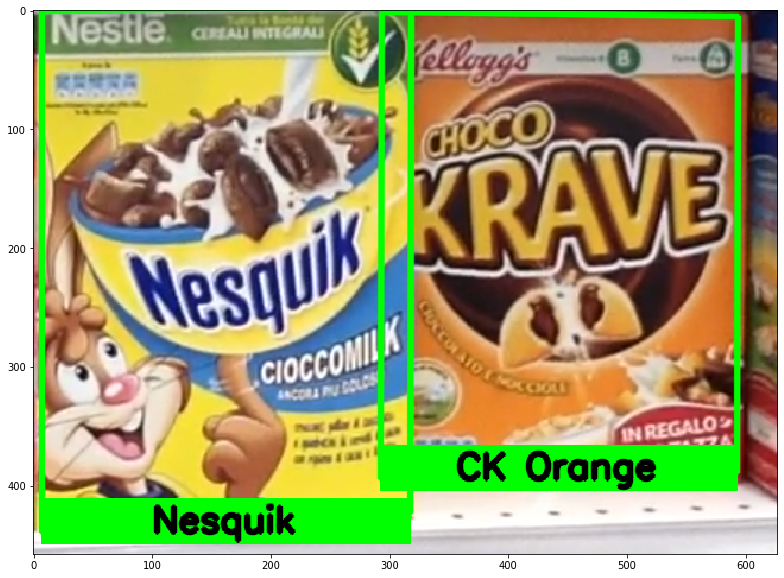

Scene e2:


Product 24 - 1 instance found:

	Instance 1: {position: (167,219), width: 340px, heigh: 491px}

Product 25 - 1 instance found:

	Instance 1: {position: (878,233), width: 304px, heigh: 447px}

Product 26 - 1 instance found:

	Instance 1: {position: (538,218), width: 330px, heigh: 490px}


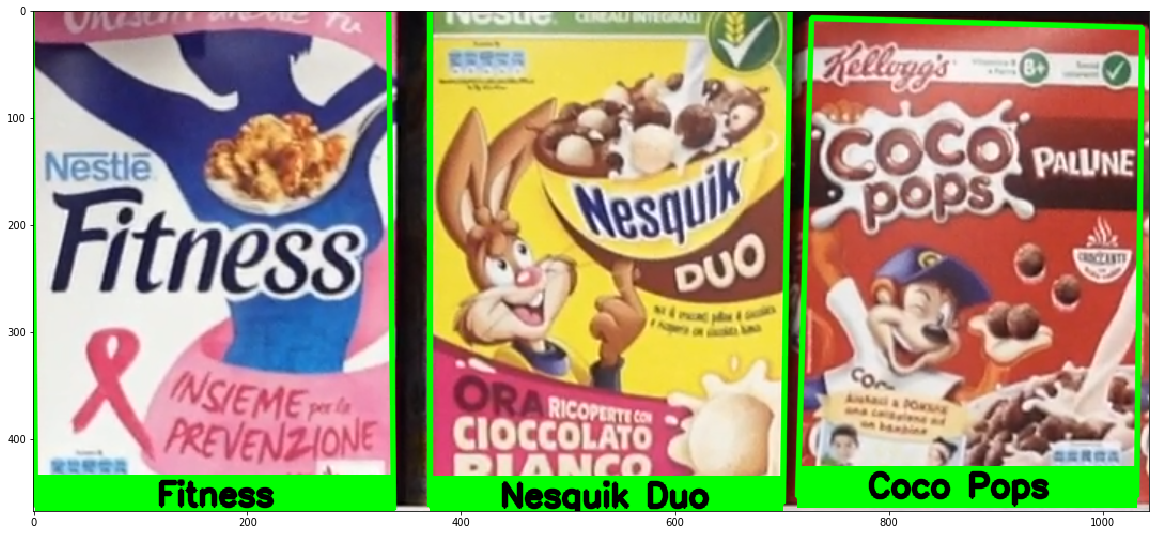

Scene e3:


Product 0 - 1 instance found:

	Instance 1: {position: (170,236), width: 327px, heigh: 445px}

Product 11 - 1 instance found:

	Instance 1: {position: (474,217), width: 304px, heigh: 400px}


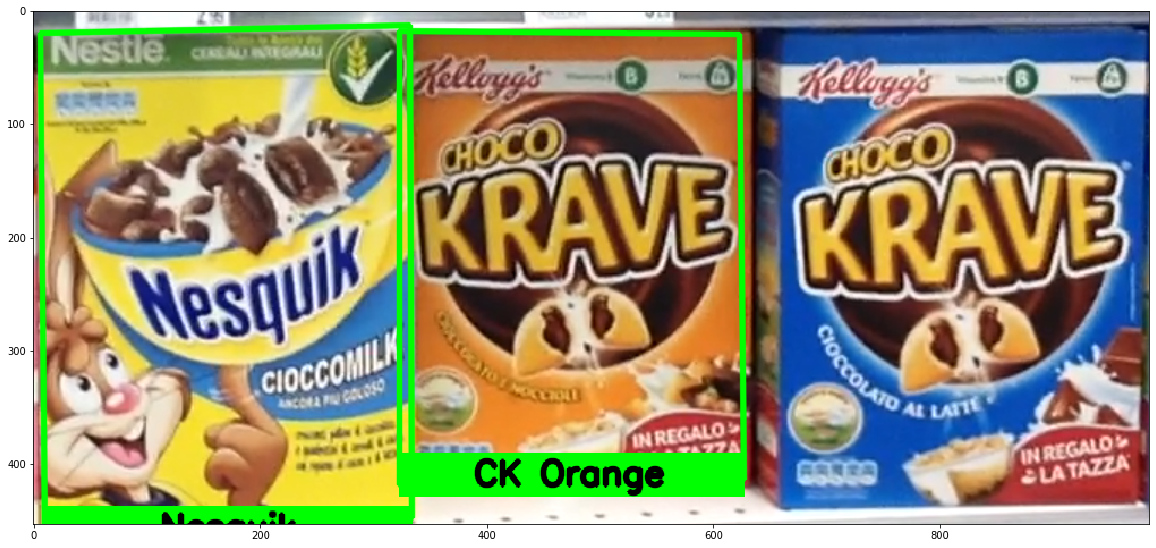

Scene e4:


Product 0 - 1 instance found:

	Instance 1: {position: (158,739), width: 327px, heigh: 446px}

Product 11 - 1 instance found:

	Instance 1: {position: (462,722), width: 305px, heigh: 399px}

Product 25 - 1 instance found:

	Instance 1: {position: (555,207), width: 316px, heigh: 447px}

Product 26 - 1 instance found:

	Instance 1: {position: (205,195), width: 344px, heigh: 497px}


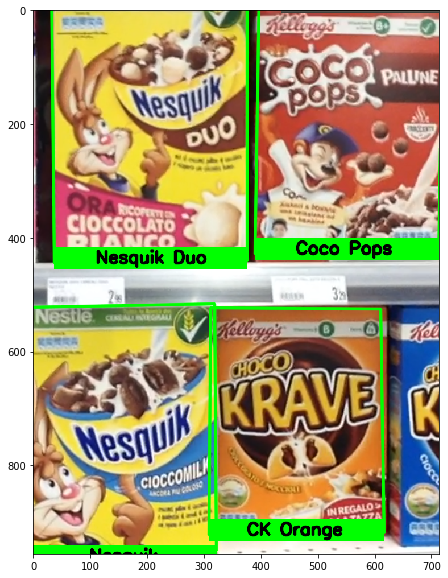

Scene e5:


Product 19 - 1 instance found:

	Instance 1: {position: (504,190), width: 292px, heigh: 386px}

Product 25 - 1 instance found:

	Instance 1: {position: (161,226), width: 312px, heigh: 444px}


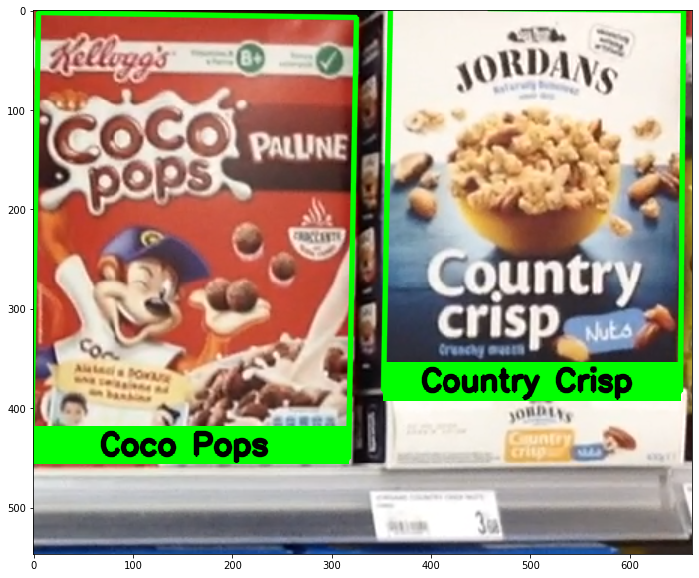

In [118]:
for i in range(num_scenes):
    #create o copy of the scene
    copy_scene = np.copy(scenes[i])
    per_check = searchTemplates_A(images, copy_scene)
    drawResults(copy_scene, per_check, scenes_names[i])

## Step B - Multiple Instance Detection

- Test on scene image: {m1.png, m2.png, m3.png, m4.png, m5.png}
- Use product images: {0.jpg, 1.jpg, 11.jpg, 19.jpg, 24.jpg, 26.jpg, 25.jpg}

In addition to what achieved at step A, the system should now be able to detect multiple instance of the
same product.

In [119]:
def readGrayImages():
    grey_scenes = {}
    for i in range(num_scenes):
        grey_scenes[i] = cv2.imread(scene_path+scenes_names[i]+scenes_estenstion, 0);
        
    return grey_scenes

In [120]:
def computeBarycenter(kp_query):
    sum_x = 0
    sum_y = 0
    for i in range(len(kp_query)):
        sum_x = sum_x + kp_query[i].pt[0]
        sum_y = sum_y + kp_query[i].pt[1]
    bar = (int(sum_x/len(kp_query)), int(sum_y/len(kp_query)))
    return bar

In [121]:
#function to compute the vectors from model's keypoints to the barycenter
def computeJoiningVectors(kp_models, barycenter):
    vectors = {}
    for i in range(len(kp_models)):
        vectors[i] = (barycenter[0] - kp_models[i].pt[0], barycenter[1] - kp_models[i].pt[1])
    return vectors

In [122]:
#function to compute the votes of the scene keypoints
def voting(imageShape, dst_points, vectors, ind_model):
    votes = []
    acc = np.zeros(imageShape)
    for j in range(len(dst_points)): 
        #dst_points[j][1] is the index of the kp_model associated with the kp_train
        vec = vectors[dst_points[j][1]]
       
        diff_scale = dst_points[j][0].size/kp_models[ind_model][dst_points[j][1]].size
        diff_rot =  (dst_points[j][0].angle - kp_models[ind_model][dst_points[j][1]].angle) * np.pi/180
        
        #rotation matrix
        rotmat = np.array([[np.cos(diff_rot), -np.sin(diff_rot)], [np.sin(diff_rot), np.cos(diff_rot)]])
        vec = rotmat @ vec
       
        vec = (diff_scale*vec[0], diff_scale*vec[1])
        
        vote = [sum(tup) for tup in zip(dst_points[j][0].pt, vec)]
            
        #check if the vote is smaller or bigger than the shape of the image
        if(vote[0]>= 0 and vote[0]<= imageShape[1] and vote[1]>= 0 and vote[1] <= imageShape[0]):
            acc[int(vote[1]), int(vote[0])] += 1
            votes.append([dst_points[j][0], (int(vote[0]), int(vote[1]))])
           
    return acc, votes

In [123]:
#function to get the list of possible barycenters, getting only those that received a vote
def getAccumulatorList(accumulator):
    l=[]
    row, col = accumulator.shape
    
    for i in range(row):
        for j in range(col):
             if(accumulator[i,j]>= 1):
                l.append([j,i])
    return l

In [124]:
#function to filter barycentres list according to votes in their neighbourhood
def outliersFilter(accumulator, RANGE, MIN_COUNT):
    
    row, col = accumulator.shape
    removed_bar = []
    count = 0
    
    accList = getAccumulatorList(accumulator)
    res = accList.copy()
    
    for k in range(len(res)):
        start_row = accList[k][1] - RANGE
        start_col = accList[k][0] - RANGE
        end_row = accList[k][1] + RANGE
        end_col = accList[k][0] + RANGE
        
        
        #check if the area is contained in the shape of the image
        if (end_row > row):
            end_row = row
        if (start_row < 0):
            start_row = 0

        if (end_col > col):
            end_col = col
        if (start_col < 0):
            start_col = 0
        
        #print("Start row: {} , end row: {}, start col: {}, end col: {} ".format(start_row, end_row, start_col, end_col))
        count = accumulator[start_row:end_row, start_col:end_col].sum()
        
        #if it is less than MIN_COUNT I add it to the elements to be removed
        if count < MIN_COUNT:
            removed_bar.append(accList[k])
        count = 0

    for i in removed_bar:
        res.remove(i)
    
    return res

In [125]:
#function to compute euclidian distance
def euclidianDistance(point_1,point_2):
    dist = np.sqrt((point_1[0]-point_2[0])**2+(point_1[1]-point_2[1])**2)
    return dist

In [126]:
#function to filter a barycentres list making mean between closest ones
def distanceFilter(barycentres, distance):
    filtered_bar = []
    len_bar = len(barycentres)
    
    for i in range(len_bar):
        
        if (barycentres[i] != [-1,-1]):
            sum_b = barycentres[i].copy()
            count_b = 1
            next_index=i+1
            
            for j in range(next_index,len_bar):
                #I do not compare with one that has already been analyzed
                if(barycentres[j] != [-1,-1]):
                    
                    dist = euclidianDistance(barycentres[i],barycentres[j])
                    #here it creates a new barycenter by averaging those found
                    if(dist<distance):
                        sum_b[0] = sum_b[0]+barycentres[j][0]
                        sum_b[1] = sum_b[1]+barycentres[j][1]
                        barycentres[j] = [-1,-1] #I put it equal to [-1, -1] so then it is no longer analyzed
                        count_b += 1
                
            #in the end I make the average
            sum_b[0] = int(round(sum_b[0] / count_b))
            sum_b[1] = int(round(sum_b[1] / count_b))
            filtered_bar.append(sum_b)
                    
    return filtered_bar

In [127]:
#function to get the Keypoints associated to a Barycenter
def getCorrectKeypoints(bar_found, votes, imageShape, good, RANGE):
    final_good=[]
    
    for vote in votes:
        #this is a barycenter voted by a single scene Keypoint
        bar_x, bar_j = (int(vote[1][0]), int(vote[1][1]))
      
        #check if the vote is contained in an area next to the real barycenter
        if (0 < bar_x < imageShape[1] and 0 <bar_j < imageShape[0]):
            
            if((bar_found[0]-RANGE < bar_x < bar_found[0]+RANGE) 
               and (bar_found[1]-RANGE < bar_j < bar_found[1]+RANGE)):
    
                final_good.append(good.get(vote[0]))
                
    return final_good

In [128]:
#function to compute the Generalized Hough Transform
def generalizedHoughTransform(grey_scene, models, des_scene):
    
    #this is where it saves the list of all barycenters for each model in the scene
    barycenters_list = {}
    final_good = {}
    threshold = 0.8
    range_outliers = 25
    count_outliers = 15
    distance = 150
    
    for i in range(len(models)):
        # Matching and finding the 2 closest elements for each query descriptor.
        matches = flann.knnMatch(des_scene,des_models[i],k=2)
    
        #get first good matches
        #matches from scene to template
        good = {}
        for m,n in matches:
            if m.distance < threshold*n.distance:
                good[kp_scene[m.queryIdx]] =  m
            
            
        #get matched Keypoints in the scene
        dst_points = []
        for k,m in good.items():
            dst_points.append((k, m.trainIdx))
    
        
        accumulator, votes = voting(grey_scene.shape, dst_points, vectors[i], i)
        
        #First filter to discard outliers
        filtered_bar = outliersFilter(accumulator, range_outliers, count_outliers)

        #Second filter to obtain a single barycenter from a group of close barycenters
        barycenters_list[i] = distanceFilter(filtered_bar, distance)
        
        #Find now the right "good" vectors for each barycenter
        final_good[i] = {}
        for j in range(len(barycenters_list[i])):
            final_good[i][j]= getCorrectKeypoints(barycenters_list[i][j], votes, grey_scene.shape, good, distance)
        
    return barycenters_list, final_good

In [129]:
def searchTemplates_B(models, scene, kp_scene, barycenters, final_good, LIMIT_INC):
    
    per_check = []
    #loop over all the possible models
    for i in range(len(models)):

        for j in range(len(barycenters[i])):
            
            per_check.extend(findPerimetersTemplates(final_good[i][j], models, scene, i, kp_scene, True))

    return per_check

In [130]:
#PARAMETERS

#SCENES IMAGES
scenes_names = ["m1","m2","m3","m4","m5"]

num_scenes = len(scenes_names)

# Checking if we found enough matching
MIN_MATCH_COUNT = 10
range_perimeter = (0.82,1.4)
LIMIT_INC = 55

In [131]:
images, scenes = readImages()
grey_scenes = readGrayImages()

barycenters = {}
vectors = {}

for i in range(num_models):
    barycenters[i] = computeBarycenter(kp_models[i])
    vectors[i] = computeJoiningVectors(kp_models[i], barycenters[i])

Scene m1:


Product 24 - 2 instance found:

	Instance 1: {position: (184,214), width: 364px, heigh: 503px}
	Instance 2: {position: (550,219), width: 340px, heigh: 491px}

Product 25 - 1 instance found:

	Instance 1: {position: (1261,232), width: 302px, heigh: 445px}

Product 26 - 1 instance found:

	Instance 1: {position: (921,218), width: 330px, heigh: 489px}


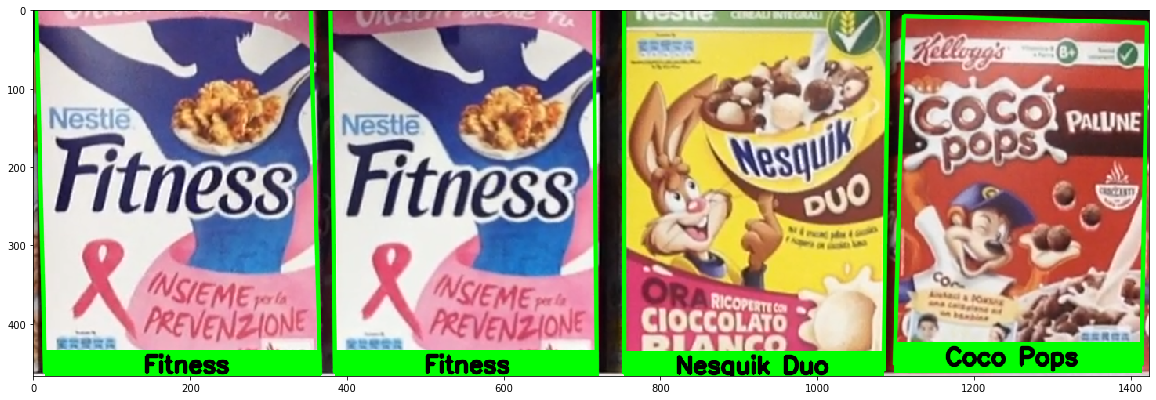

Scene m2:


Product 0 - 1 instance found:

	Instance 1: {position: (178,300), width: 348px, heigh: 454px}

Product 1 - 2 instance found:

	Instance 1: {position: (1180,285), width: 296px, heigh: 415px}
	Instance 2: {position: (848,287), width: 314px, heigh: 415px}

Product 11 - 1 instance found:

	Instance 1: {position: (509,282), width: 311px, heigh: 403px}


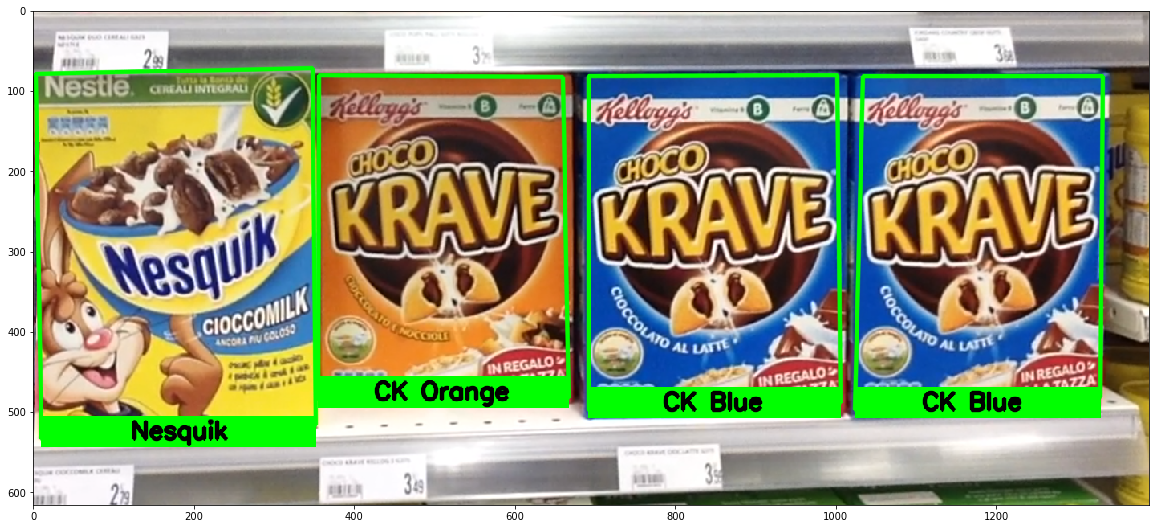

Scene m3:


Product 19 - 1 instance found:

	Instance 1: {position: (1232,189), width: 291px, heigh: 386px}

Product 25 - 2 instance found:

	Instance 1: {position: (890,226), width: 312px, heigh: 443px}
	Instance 2: {position: (558,220), width: 331px, heigh: 454px}

Product 26 - 1 instance found:

	Instance 1: {position: (195,206), width: 364px, heigh: 510px}


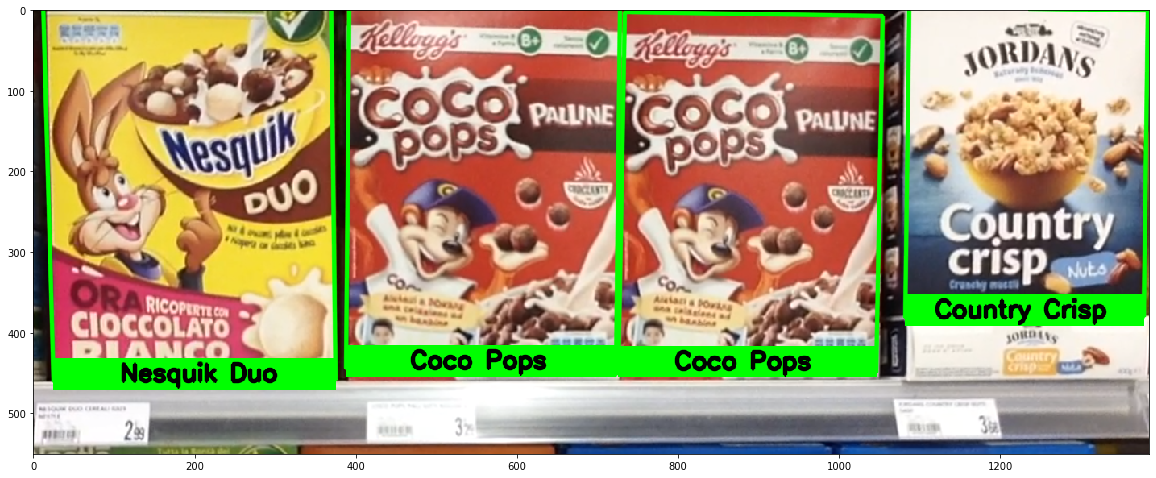

Scene m4:


Product 24 - 2 instance found:

	Instance 1: {position: (161,192), width: 377px, heigh: 507px}
	Instance 2: {position: (540,196), width: 360px, heigh: 502px}

Product 25 - 1 instance found:

	Instance 1: {position: (1588,212), width: 298px, heigh: 437px}

Product 26 - 1 instance found:

	Instance 1: {position: (921,195), width: 344px, heigh: 497px}


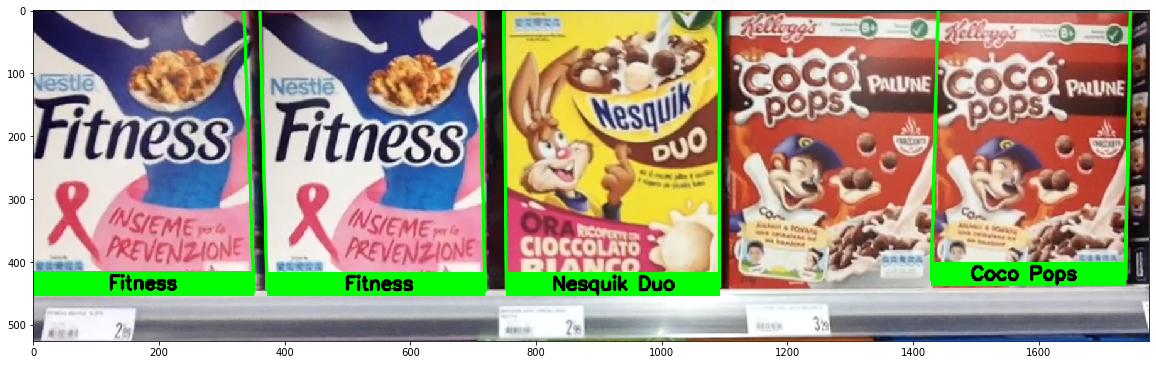

Scene m5:


Product 1 - 2 instance found:

	Instance 1: {position: (500,750), width: 314px, heigh: 415px}
	Instance 2: {position: (832,746), width: 297px, heigh: 417px}

Product 11 - 1 instance found:

	Instance 1: {position: (162,743), width: 312px, heigh: 403px}

Product 19 - 1 instance found:

	Instance 1: {position: (908,189), width: 291px, heigh: 387px}

Product 25 - 2 instance found:

	Instance 1: {position: (234,221), width: 332px, heigh: 455px}
	Instance 2: {position: (566,228), width: 313px, heigh: 446px}


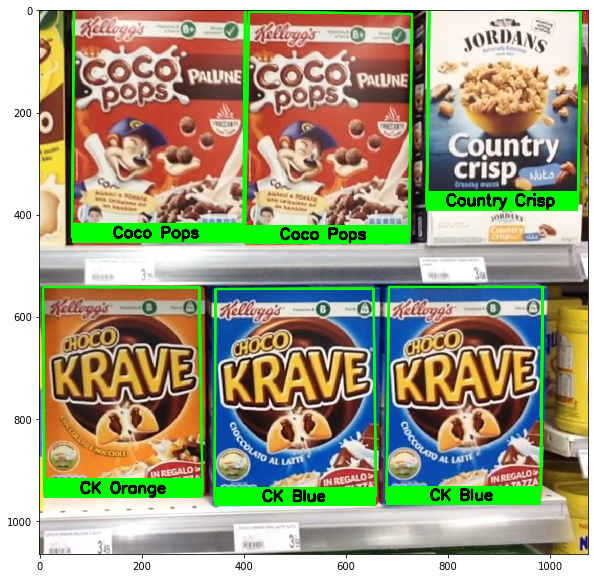

In [134]:
for i in range(num_scenes):
    copy_scene = np.copy(scenes[i])
    kp_scene = sift.detect(grey_scenes[i])
    kp_scene, des_scene = sift.compute(grey_scenes[i], kp_scene)
    barycenters_list, final_good = generalizedHoughTransform(grey_scenes[i], images, des_scene)
    per_check = searchTemplates_B(images, copy_scene, kp_scene, barycenters_list, final_good, LIMIT_INC)
    drawResults(copy_scene, per_check, scenes_names[i])

# Correction Step A

The method that takes advantage of the Generalized Hough Transform can be used to correct the e3 scene error where both Choco Krave boxes are not detected. 

Scene e3:


Product 0 - 1 instance found:

	Instance 1: {position: (170,236), width: 327px, heigh: 444px}

Product 1 - 1 instance found:

	Instance 1: {position: (818,223), width: 305px, heigh: 406px}

Product 11 - 1 instance found:

	Instance 1: {position: (474,216), width: 304px, heigh: 394px}


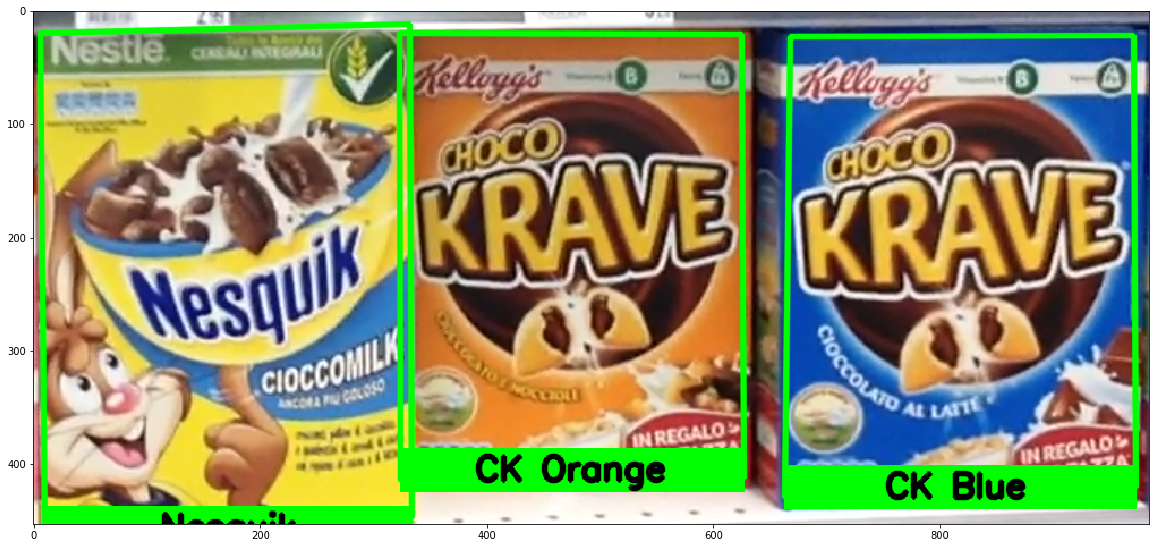

In [133]:
MIN_MATCH_COUNT = 30

scene_name = "e3"


scene =  cv2.imread(scene_path+scene_name+scenes_estenstion);
scene = cv2.cvtColor(scene,cv2.COLOR_BGR2RGB);
grey_scene = cv2.imread(scene_path+scene_name+scenes_estenstion, 0);
        

copy_scene = np.copy(scene)
kp_scene = sift.detect(grey_scene)
kp_scene, des_scene = sift.compute(grey_scene, kp_scene)
barycenters_list, final_good = generalizedHoughTransform(grey_scene, images, des_scene)
per_check = searchTemplates_B(images, copy_scene, kp_scene, barycenters_list, final_good, LIMIT_INC)
drawResults(copy_scene, per_check, scene_name)